# Quick Start

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

## Setup

First, install the required packages:

In [1]:
%%capture --no-stderr
!pip install langchain langchain-google-genai langgraph

In [2]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [3]:
import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "chatbot01"

In [44]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI (
  api_key=GEMINI_API_KEY, max_retries = 2, model="gemini-1.5-flash")

In [45]:
llm.invoke("greet me, Saqlai")

AIMessage(content='Hello Saqlai, how are you doing today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b72017e9-61e1-436b-868b-d647686ab261-0', usage_metadata={'input_tokens': 7, 'output_tokens': 11, 'total_tokens': 18, 'input_token_details': {'cache_read': 0}})

## Start Building Chatbot using LangGraph
## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [8]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph

class State(TypedDict):
  messages: Annotated[list,add_messages]


In [9]:
new_message_1 = [{"role":"user","content":"Hello, how are you?"}]
new_message_2 = [{"role":"ai","content":"Hi there?"}]
messages = add_messages(new_message_1,new_message_2)

In [10]:
print(messages)

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='61c34bfd-8d13-4009-a324-f67141c70f7f'), AIMessage(content='Hi there?', additional_kwargs={}, response_metadata={}, id='391f865d-e2cb-4af1-8b5d-61e469435ed9')]


In [46]:
def chatbot(state:State) -> State:
  return {"messages": [llm.invoke(state["messages"])]}

In [47]:
builder : StateGraph = StateGraph(State)
# create chatbot Node
builder.add_node("chatbot", chatbot)
# create edge
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

In [48]:
graph : CompiledStateGraph = builder.compile()

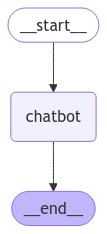

In [49]:
from IPython.display import display, Image
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [50]:
graph.invoke({"messages": [{"role": "user", "content": "what you know about Imran Khan"}]})

{'messages': [HumanMessage(content='what you know about Imran Khan', additional_kwargs={}, response_metadata={}, id='1b38a2eb-8d05-4435-82bf-079fcc3c2428'),
  AIMessage(content='## Imran Khan: A Multifaceted Figure\n\nImran Khan is a Pakistani politician, former cricketer, and philanthropist who served as the 22nd Prime Minister of Pakistan from 2018 to 2022. He is a controversial figure, known for his charisma, political ambition, and strong stances on various issues.\n\n**Here\'s a summary of key aspects of his life and career:**\n\n**Early Life and Cricket Career:**\n\n* Born in Lahore, Pakistan, in 1952.\n* Studied at Oxford University, where he excelled in cricket.\n* Became a renowned all-rounder for Pakistan\'s national cricket team.\n* Led Pakistan to victory in the 1992 Cricket World Cup, becoming a national icon.\n\n**Political Career:**\n\n* Founded the Pakistan Tehreek-e-Insaf (PTI) party in 1996.\n* Advocated for social justice, economic development, and a corruption-free 

In [54]:
for event in graph.stream({"messages": [("user", "I am Saqlain")]}):
  print("EVENT:", list(event.values())[0]["messages"][-1].content)

EVENT: Hello Saqlain! It's nice to meet you. What can I do for you today? 



In [56]:
# from threading import Event
# from pprint import pprint
# while True:
#   user_input = input("Enter your message: ")
#   if user_input.lower() in ["exit", "quit"]:
#     pprint("Good Bye...")
#     break
#   for event in graph.stream({"messages": ("user",user_input)}):
#     pprint(event.values())
#     for value in event.values():
#       pprint(value["messages"])
#       print("Assistant: ",value["messages"].content)



In [57]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("Enter your message: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about Imran Khan?"
        print("Enter your message: " + user_input)
        stream_graph_updates(user_input)
        break

Enter your message: good
Assistant: I'm glad you think so! 

What's good about?  Tell me more so I can understand what you're referring to. 

Enter your message: 
Assistant: Please provide me with some context or a question so I can assist you. I need more information to understand what you're looking for. 

Enter your message: q
Goodbye!
